# MELBOURNE HOUSING PROJECT 

# I. Introduction

- The main target of the project is to apply linear regression model

- Specifically, the task is to predict housing prices in Melbourne

# II. Datasets description 

This data was scraped from publicly available results posted every week from Domain.com.au. The dataset includes Address, Type of Real estate, Suburb, Method of Selling, Rooms, Price, Real Estate Agent, Date of Sale and distance from C.B.D.

https://www.kaggle.com/anthonypino/melbourne-housing-market

# III. Content

In [43]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split, cross_val_predict
from sklearn.linear_model import LinearRegression

import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import mean_squared_error
from math import sqrt
import seaborn as sns

df = pd.read_csv('D:\\Nhat\\ML course\\Assignment\\Assignment 3\\MELBOURNE_HOUSE_PRICES_LESS.csv')

# modify the number of maximum displayed rows and columns
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)


# 1. Data visualization 

In [4]:
df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Postcode,Regionname,Propertycount,Distance,CouncilArea
0,Abbotsford,49 Lithgow St,3,h,1490000.0,S,Jellis,1/04/2017,3067,Northern Metropolitan,4019,3.0,Yarra City Council
1,Abbotsford,59A Turner St,3,h,1220000.0,S,Marshall,1/04/2017,3067,Northern Metropolitan,4019,3.0,Yarra City Council
2,Abbotsford,119B Yarra St,3,h,1420000.0,S,Nelson,1/04/2017,3067,Northern Metropolitan,4019,3.0,Yarra City Council
3,Aberfeldie,68 Vida St,3,h,1515000.0,S,Barry,1/04/2017,3040,Western Metropolitan,1543,7.5,Moonee Valley City Council
4,Airport West,92 Clydesdale Rd,2,h,670000.0,S,Nelson,1/04/2017,3042,Western Metropolitan,3464,10.4,Moonee Valley City Council


### feature ' Postcode' should be converted to categorical feature instead of numeric 
### feature 'Propertycount' accounts for the unique number of properties in that suburb, thus should be categorical

In [5]:
df.Postcode = df.Postcode.astype('object')
df.Propertycount = df.Propertycount.astype('object')

### The data consists of 63023 rows and 13 columns.
### The predicted target is 'Price'. In conclusion, there are 12 feature: 2 numeric and 10 categorical

In [6]:
df.select_dtypes(include=np.number).shape

(63023, 3)

In [7]:
df.select_dtypes(include=object).shape

(63023, 10)

### There are 14590 (23.15 %) missing values in the 'Price' target. In this case we will drop these missing values

In [8]:
df.isnull().sum()

Suburb               0
Address              0
Rooms                0
Type                 0
Price            14590
Method               0
SellerG              0
Date                 0
Postcode             0
Regionname           0
Propertycount        0
Distance             0
CouncilArea          0
dtype: int64

In [9]:
14590/63023

0.23150278469765007

# 2. Feature selection

### numeric feature

In [10]:
df.drop(columns='Price').describe()

,Rooms,Distance
count,63023.000000,63023.000000
mean,3.110595,12.684829
std,0.957551,7.592015
min,1.000000,0.000000
25%,3.000000,7.000000
50%,3.000000,11.400000
75%,4.000000,16.700000
max,31.000000,64.100000


### correlation: there's no such large correlation among numeric features

In [11]:
df.select_dtypes(np.number).drop(columns='Price').corr()

,Rooms,Distance
Rooms,1.000000,0.268289
Distance,0.268289,1.000000


### The categorical features contains too many unique values, which might cause serious overfitting. The 'Address' feature (57754 values) will be dropped since it will be useless for training for the model

In [12]:
df.drop(columns='Price').describe(include='O')

,Suburb,Address,Type,Method,SellerG,Date,Postcode,Regionname,Propertycount,CouncilArea
count,63023,63023,63023,63023,63023,63023,63023,63023,63023,63023
unique,380,57754,3,9,476,112,225,8,368,34
top,Reservoir,5 Charles St,h,S,Barry,24/03/2018,3073,Southern Metropolitan,21650,Boroondara City Council
freq,1241,7,45053,34063,6894,1144,1241,17559,1241,5132


### correlation: there is large correlation between 'Suburb' and 'Propertycount' feature                                               -> remove  'Propertycount' feature

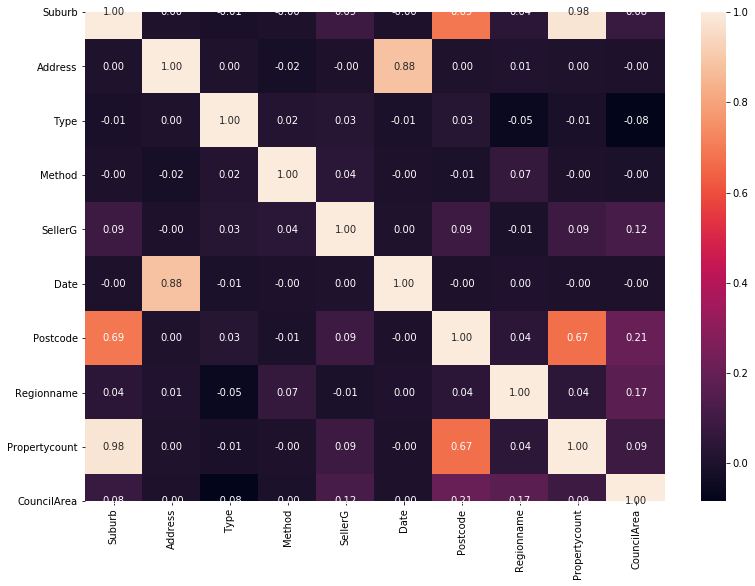

In [13]:
corr_cat = df.select_dtypes(object).apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
plt.figure(figsize=(13,9))
sns.heatmap(corr_cat, xticklabels=corr_cat.columns.values, yticklabels=corr_cat.columns.values, annot=True, fmt=".2f")
plt.show()

# 3. Data transformation 

### - remove 'Address' and 'Propertycount' feature 
### - convert 'Date' from string -> Datetime, the convert to format Year-Month
### - drop all missing values (drop 14590 rows)

In [14]:
new_df = df.copy()

#drop the address column
new_df = df.drop(columns=['Address','Propertycount'])

#convert from format dd-mm-yy to format yy-mm
new_df["Date"] = pd.to_datetime(new_df["Date"]).apply(lambda x: x.strftime('%Y-%m'))

#drop all missing values 
df2 = new_df.dropna()

### new data frame after modification

In [15]:
df2.head()

,Suburb,Rooms,Type,Price,Method,SellerG,Date,Postcode,Regionname,Distance,CouncilArea
0,Abbotsford,3,h,1490000.0,S,Jellis,2017-01,3067,Northern Metropolitan,3.0,Yarra City Council
1,Abbotsford,3,h,1220000.0,S,Marshall,2017-01,3067,Northern Metropolitan,3.0,Yarra City Council
2,Abbotsford,3,h,1420000.0,S,Nelson,2017-01,3067,Northern Metropolitan,3.0,Yarra City Council
3,Aberfeldie,3,h,1515000.0,S,Barry,2017-01,3040,Western Metropolitan,7.5,Moonee Valley City Council
4,Airport West,2,h,670000.0,S,Nelson,2017-01,3042,Western Metropolitan,10.4,Moonee Valley City Council


In [16]:
df2.describe(include='O')

,Suburb,Type,Method,SellerG,Date,Postcode,Regionname,CouncilArea
count,48433,48433,48433,48433,48433,48433,48433,48433
unique,370,3,5,422,35,221,8,34
top,Reservoir,h,S,Barry,2018-03,3073,Northern Metropolitan,Darebin City Council
freq,1067,34161,30624,4818,2376,1067,13598,3462


# 4. Data visualization after transformation

### scatter plot of features regarding 'Price'

### Rooms

there is a sample, which might seem like an outlier (31 rooms, but price is low as well)

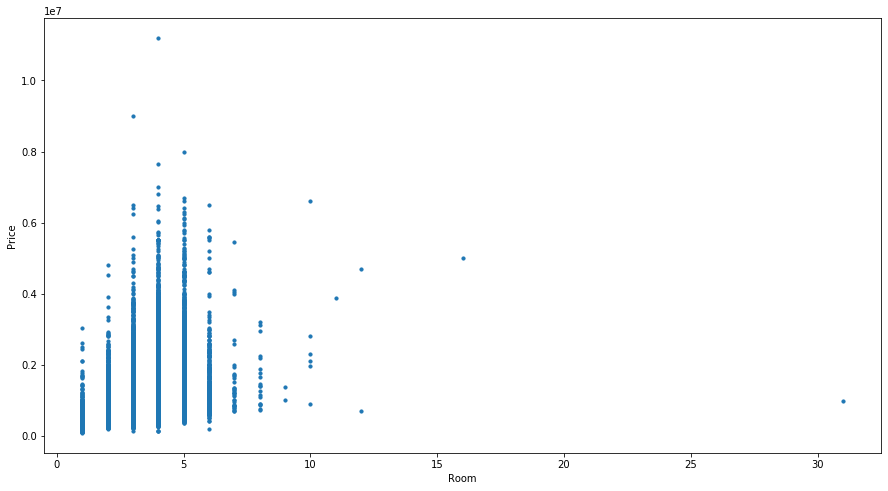

In [18]:
plt.figure(num=2, figsize=(15,8))

x = df2.sort_values(by='Date').Rooms
y = df2.sort_values(by='Date').Price

plt.xlabel('Room')
plt.ylabel('Price')

plt.scatter(x, y, s=10)
plt.show()

### Distance

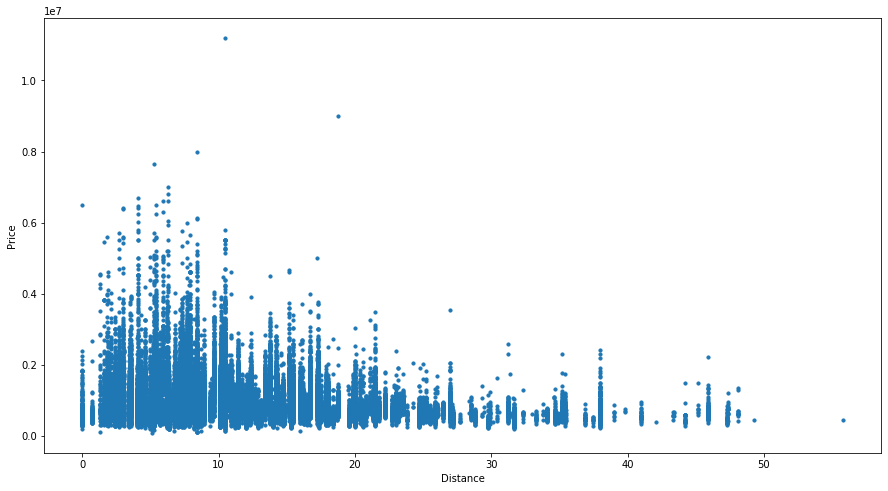

In [19]:
plt.figure(num=3, figsize=(15,8))

x = df2.sort_values(by='Date').Distance
y = df2.sort_values(by='Date').Price

plt.xlabel('Distance')
plt.ylabel('Price')

plt.scatter(x, y, s=10)
plt.show()

### Type

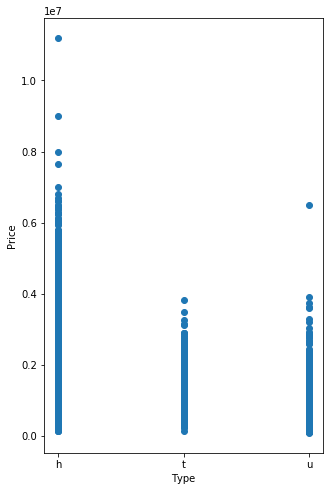

In [20]:
plt.figure(num=4, figsize=(5,8))

x = df2.sort_values(by='Date').Type.values
y = df2.sort_values(by='Date').Price.values

plt.xlabel('Type')
plt.ylabel('Price')

plt.scatter(x, y)
plt.show()

### Method 

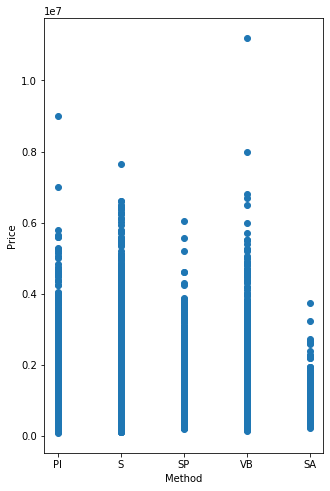

In [21]:
plt.figure(num=5, figsize=(5,8))

x = df2.sort_values(by='Date').Method.values
y = df2.sort_values(by='Date').Price.values

plt.xlabel('Method')
plt.ylabel('Price')

plt.scatter(x, y)
plt.show()

### Regionname

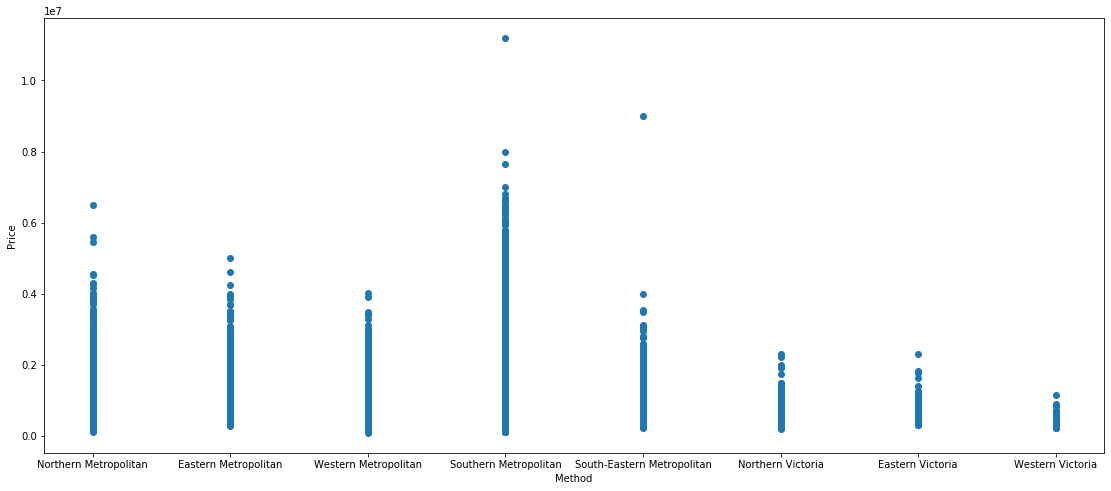

In [22]:
plt.figure(num=6, figsize=(19,8))

x = df2.sort_values(by='Date').Regionname.values
y = df2.sort_values(by='Date').Price.values

plt.xlabel('Method')
plt.ylabel('Price')

plt.scatter(x, y)
plt.show()

### Based on the graphs, the 'Price' values are densly scattered at value below 5 millions AUS
### The scattered values in the numerical-feature graphs look similar to each other

# 5. Data preprocessing, training and evaluating the model 

### using 5-fold cross validation

In [41]:
def KFold_score(X, y): 
    #create 5-fold object
    folds = KFold(n_splits=5, shuffle=True,random_state=0)
    
    score_test, score_train, rmse_train, rmse_test = [], [], [], []
   
    for train_index, test_index in folds.split(X, y):
        #split the data
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    
        #create linear regression object
        model = LinearRegression()
        model.fit(X_train, y_train)
        
        y_train_predict = model.predict(X_train)
        y_test_predict = model.predict(X_test)
        
        rmse_train.append(sqrt(mean_squared_error(y_train, y_train_predict)))
        rmse_test.append(sqrt(mean_squared_error(y_test, y_test_predict)))
        
        #predict X_test and calculate the accuracy based on the y_test, then compute the mean accuracy of 5 different sets
        score_train.append(model.score(X_train, y_train))
        score_test.append(model.score(X_test, y_test))
        
    print(f'Accuracy on the train set: {score_train} \nMean accuracy = {np.array(score_train).mean()}')
    print(f'RMSE= {np.array(rmse_train).mean()}')
    
    print(f'\nAccuracy on the test set: {score_test} \nMean accuracy = {np.array(score_test).mean()}')
    print(f'RMSE= {np.array(rmse_test).mean()}')

### train model 

In [24]:
feature = df2.drop(columns='Price')
target = df2['Price']

### Without PCA

In [25]:
ohe_feature = pd.get_dummies(feature)
scaler = MinMaxScaler(feature_range=(0,1)).fit_transform(ohe_feature)

# feature
X = scaler

# target
y = target.values.reshape(-1,1)

In [26]:
X.shape

(48433, 1100)

In [42]:
KFold_score(X, y)

Accuracy on the train set: [0.6654658229260384, 0.659393362450568, 0.6722785421130323, 0.6721477382415507, 0.6700012464028402] 
Mean accuracy = 0.6678573424268059
RMSE= 342033.432866757

Accuracy on the test set: [-6.52476614341985e+20, -6.286071021111926e+20, -5.607048275552581e+21, -8.194553344033784e+21, -1.2886120562800638e+21] 
Mean accuracy = -3.2742594784639215e+21
RMSE= 2.9894928829715724e+16


### The model is predicting very well on the training set (mean accuracy 67%) but is predicting very badly on the test set. Thus the model is overfitting.

### With PCA

In [28]:
ohe_feature1 = pd.get_dummies(feature)
scaler1 = MinMaxScaler(feature_range=(0,1)).fit_transform(ohe_feature1)

pca = PCA(n_components=550)
# feature
X1 = pca.fit_transform(scaler1)

# target
y1 = target.values.reshape(-1,1)

In [29]:
X1.shape

(48433, 550)

In [39]:
KFold_score(X1, y1)

Accuracy on the train set: 
Mean accuracy = 0.6683285500916044
RMSE= 341793.5452715772

Accuracy on the test set: 
Mean accuracy = 0.6573366693211294
RMSE= 347339.3360734149


### The model when applying PCA is doing much better on the test set whilst the train set. 

## Residual Plot 

### plotting 5 different residual plots based on 5 different CV sets 

In [31]:
from yellowbrick.regressor import ResidualsPlot
def residual(X, y):    
    folds = KFold(n_splits=5, shuffle=True,random_state=0)

    for train_index, test_index in folds.split(X, y):
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]

        model = ResidualsPlot(LinearRegression())
        model.fit(X_train, y_train)
        model.score(X_test, y_test)
        model.show()

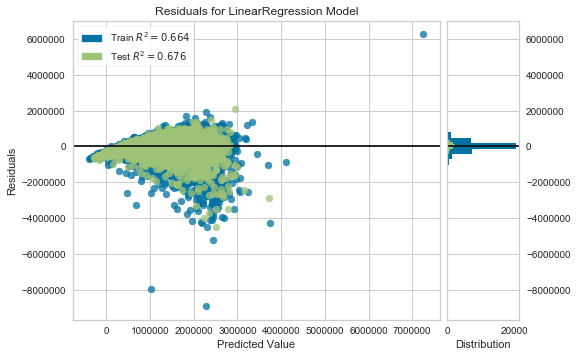

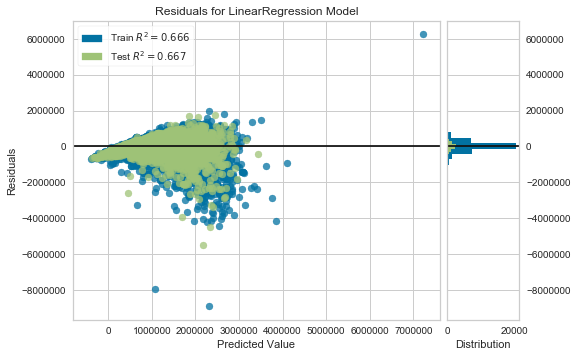

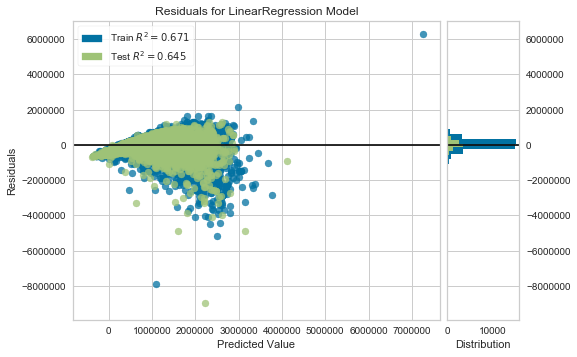

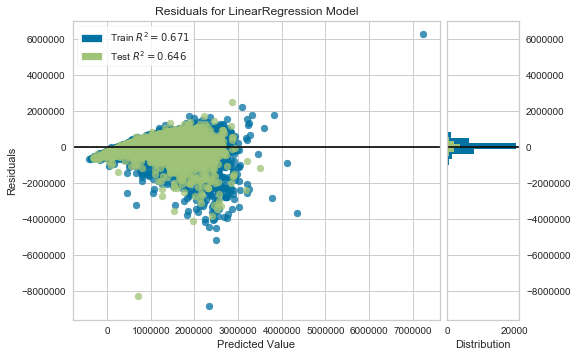

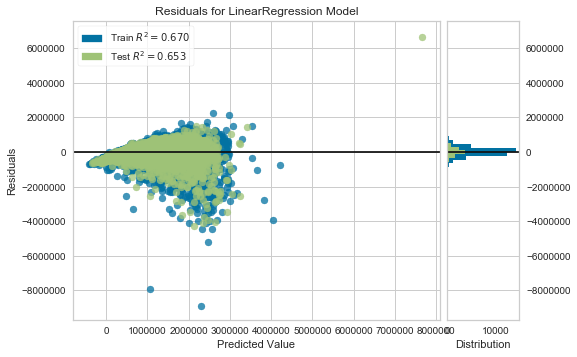

In [32]:
residual(X1, y1)

### Heteroskedasticity

## 5. Conclusion 

There too many categorical features, in which there are too many unique values as well, that causes overfitting. 
There too many samples as compared to the number of features, which might cause underfitting. 

### PCA considerably resolves overfitting:

### Without PCA 

Accuracy on the train set: 
Mean accuracy = 0.6678573424268059; 
RMSE= 342033.432866757

Accuracy on the test set: 
Mean accuracy = -3.2742594784639215e+21; 
RMSE= 2.9894928829715724e+16

### With PCA

Accuracy on the train set: 
Mean accuracy = 0.6683285500916044;
RMSE= 341793.5452715772

Accuracy on the test set: 
Mean accuracy = 0.6573366693211294;
RMSE= 347339.3360734149